In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# ML models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# ---------------------------
# 1. Load & Clean Data
# ---------------------------
df = pd.read_csv("Kgp_weather_last10.csv")

# Drop initial rows
df = df.iloc[2:].copy()
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)



In [2]:
df.head()

2,time,temperature_2m_mean (°C),rain_sum (mm),sunrise (iso8601),precipitation_sum (mm),NaN
0,01-01-2015,19.4,41.7,2015-01-01T00:50,41.7,NaN
1,02-01-2015,22.1,5.9,2015-01-02T00:50,5.9,NaN
2,03-01-2015,22.5,9.8,2015-01-03T00:50,9.8,NaN
3,04-01-2015,20.9,0,2015-01-04T00:51,0,NaN
4,05-01-2015,18.7,0,2015-01-05T00:51,0,NaN


In [4]:
# Keep required columns
df = df[['time', 'temperature_2m_mean (°C)','rain_sum (mm)','sunrise (iso8601)','precipitation_sum (mm)']]

df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')
df = df.sort_values('time')

C:\Users\sneha\AppData\Local\Temp\ipykernel_54224\4011039829.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')


In [5]:
df.head()

2,time,temperature_2m_mean (°C),rain_sum (mm),sunrise (iso8601),precipitation_sum (mm)
0,2015-01-01,19.4,41.7,2015-01-01T00:50,41.7
31,2015-01-02,17.4,0,2015-02-01T00:49,0
59,2015-01-03,25.5,0,2015-03-01T00:32,0
90,2015-01-04,29.3,2.5,2015-04-01T00:03,2.5
120,2015-01-05,30.6,0.3,2015-04-30T23:38,0.3


In [7]:
df = df[['time', 'temperature_2m_mean (°C)', 'rain_sum (mm)']].copy()
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Drop or fill missing values
df = df.dropna(subset=['temperature_2m_mean (°C)', 'rain_sum (mm)'])
# OR: df = df.fillna(method='ffill')


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# ---------------------------
# 1. Preprocess data
# ---------------------------

# Keep only relevant columns
df = df[['time', 'temperature_2m_mean (°C)', 'rain_sum (mm)']].copy()
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# Scale features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['temperature_2m_mean (°C)', 'rain_sum (mm)']])

# Helper to create sequences
def create_sequences(data, past_days=30, future_days=7):
    X, y = [], []
    for i in range(len(data) - past_days - future_days):
        X.append(data[i:i+past_days])
        y.append(data[i+past_days:i+past_days+future_days])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, past_days=30, future_days=7)

# Train-test split
split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 2. LSTM model
# ---------------------------
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(y_train.shape[1]*y_train.shape[2])  # flatten output
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    validation_split=0.1, epochs=20, batch_size=32, verbose=1)

# Predict
y_pred_lstm = model.predict(X_test)
y_pred_lstm = y_pred_lstm.reshape(y_test.shape)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,2)).reshape(y_test.shape)
y_pred_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1,2)).reshape(y_pred_lstm.shape)

# Metrics for LSTM
def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true.reshape(-1,2), y_pred.reshape(-1,2))
    rmse = mean_squared_error(y_true.reshape(-1,2), y_pred.reshape(-1,2), squared=False)
    r2 = r2_score(y_true.reshape(-1,2), y_pred.reshape(-1,2))
    print(f"{name}:\n  MAE: {mae:.3f}\n  RMSE: {rmse:.3f}\n  R²: {r2:.3f}\n")

evaluate(y_test_inv, y_pred_inv, "LSTM")

# ---------------------------
# 3. Linear Regression
# ---------------------------
X_lr = X.reshape(X.shape[0], -1)
y_lr = y.reshape(y.shape[0], -1)

X_train_lr, X_test_lr = X_lr[:split], X_lr[split:]
y_train_lr, y_test_lr = y_lr[:split], y_lr[split:]

lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

y_test_lr_inv = scaler.inverse_transform(y_test_lr.reshape(-1,2)).reshape(y_test.shape)
y_pred_lr_inv = scaler.inverse_transform(y_pred_lr.reshape(-1,2)).reshape(y_test.shape)

evaluate(y_test_lr_inv, y_pred_lr_inv, "Linear Regression")

# ---------------------------
# 4. Random Forest
# ---------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_lr, y_train_lr)
y_pred_rf = rf.predict(X_test_lr)

y_pred_rf_inv = scaler.inverse_transform(y_pred_rf.reshape(-1,2)).reshape(y_test.shape)

evaluate(y_test_lr_inv, y_pred_rf_inv, "Random Forest")


Epoch 1/20


c:\Users\sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0719 - val_loss: 0.0155
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0200 - val_loss: 0.0153
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0189 - val_loss: 0.0149
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0177 - val_loss: 0.0144
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161 - val_loss: 0.0132
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0156 - val_loss: 0.0130
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0158 - val_loss: 0.0127
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0144 - val_loss: 0.0133
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0137 - val_loss: 0.01

c:\Users\sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest:
  MAE: 3.725
  RMSE: 6.053
  R²: 0.363



c:\Users\sneha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

def evaluate(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true.reshape(-1,2), y_pred.reshape(-1,2))
    rmse = root_mean_squared_error(y_true.reshape(-1,2), y_pred.reshape(-1,2))
    r2 = r2_score(y_true.reshape(-1,2), y_pred.reshape(-1,2))
    
    print("="*40)
    print(f"{name} Evaluation")
    print("="*40)
    print(f" MAE  : {mae:.3f}")
    print(f" RMSE : {rmse:.3f}")
    print(f" R²   : {r2:.3f}\n")


In [11]:
def plot_predictions(y_true, y_pred, var_idx=0, var_name="Temperature"):
    plt.figure(figsize=(12,4))
    plt.plot(y_true.reshape(-1,2)[:,var_idx], label=f"Actual {var_name}", color="black")
    plt.plot(y_pred.reshape(-1,2)[:,var_idx], label=f"Predicted {var_name}", alpha=0.7)
    plt.legend()
    plt.title(f"{var_name} Prediction vs Actual")
    plt.show()


LSTM Evaluation
 MAE  : 4.236
 RMSE : 6.488
 R²   : 0.242



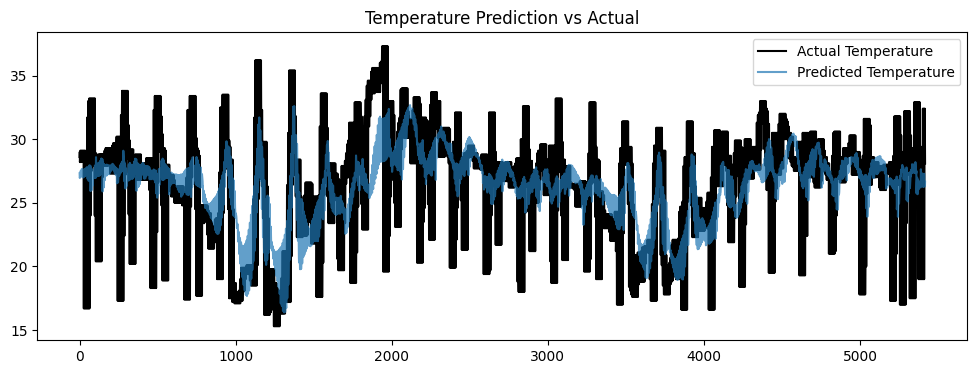

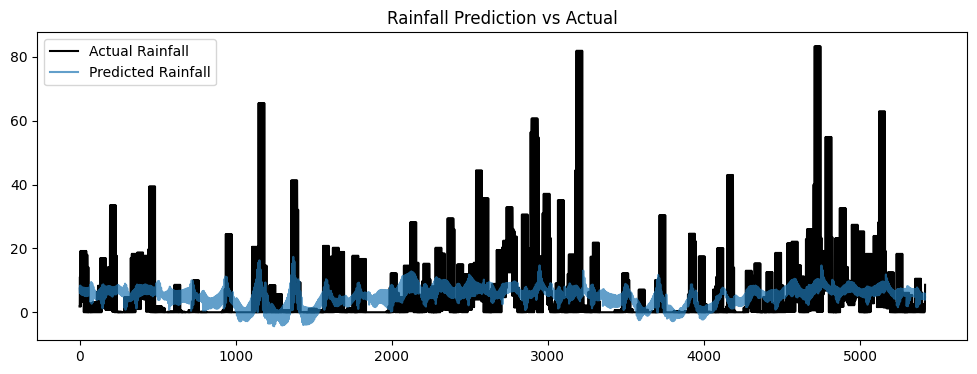

Linear Regression Evaluation
 MAE  : 4.090
 RMSE : 6.283
 R²   : 0.296

Random Forest Evaluation
 MAE  : 3.725
 RMSE : 6.053
 R²   : 0.363



In [12]:
# Evaluate LSTM
evaluate(y_test_inv, y_pred_inv, "LSTM")
plot_predictions(y_test_inv, y_pred_inv, var_idx=0, var_name="Temperature")
plot_predictions(y_test_inv, y_pred_inv, var_idx=1, var_name="Rainfall")

# Evaluate Linear Regression
evaluate(y_test_lr_inv, y_pred_lr_inv, "Linear Regression")

# Evaluate Random Forest
evaluate(y_test_lr_inv, y_pred_rf_inv, "Random Forest")
